In [1]:
import geopandas
import rasterio
import rasterio.plot
from rasterio.windows import Window
import matplotlib.pyplot as plt

# Labelled vector/raster data in layers
GDB = '../src/deepmap/data/kreike/KreikeSampleExtractedDataNam52022.gdb/'

In [2]:
# Very detailed raster data (the actual Aerial images)
# Download a large file, cache and make it available locally.
# This cell will take a long time to run initially, but should be fast
# in subsequent executions.

# We don't want to assume that our package is installed,
# but keep these notebooks as lightweight and portable as possible.
import sys; sys.path.append("../src/deepmap/data")
from ondemand import get_file
TIFF = get_file("aerial_1970_clipped")

## Subset a large TIFF file to a region of interest

The input `TIFF` above covers the entire area that we're ever likely to encounter, and is huge (3.6Gb) and prohibitive to work with. Only a small subset of this `TIFF` is likely to have useful information for our purpose (The *Omutis* or settlements in this example). Further, we need to learn how to do this to feed raster data from this TIFF piecemeal to an ML model down the line anyway.

We define a function to do so. Inline comments in the code below.

In [11]:
def subset_tif(input_tif, output_tif, gdf, band_index=1):
    """
    Subset an input tif using boundaries obtained from a GeoDataFrame gdf,
    (which can be queried/filtered using geopandas easily),
    and save as output tif.
    """
    
    with rasterio.open(input_tif) as raster:
        # We shouldn't be doing this if the crs don't match
        if raster.crs != gdf.crs:
            raise AssertionError

        _minx, _miny, _maxx, _maxy = tuple(gdf.total_bounds)
        
        # Note the "~" since we're transforming gdf coordinates
        # "to" raster coordinates, not the other way around.
        _col_off1, _row_off1 = ~raster.transform * (_minx, _miny)
        _col_off2, _row_off2 = ~raster.transform * (_maxx, _maxy)
        _width, _height = _col_off2-_col_off1, _row_off1-_row_off2

        window = Window(
            _col_off1,
            _row_off2,
            _width,
            _height
        )

        band = raster.read(
            band_index,
            window=window
        )

    with rasterio.open(
            output_tif,
            mode='w',
            driver='GTiff',
            height=band.shape[0],
            width=band.shape[1],
            count=1,
            dtype=band.dtype,
            crs=raster.crs.wkt,
            transform=rasterio.windows.transform(window, raster.transform),
    ) as new_dataset:
        new_dataset.write(band, indexes=1)

### Subset and plot the truncated TIFF file

CRS of the Input tif is EPSG:32733
CRS of the subsetted tif is EPSG:32733


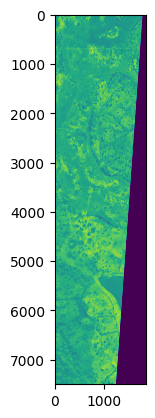

In [12]:
with rasterio.open(TIFF, 'r') as raster:
    print('CRS of the Input tif is {}'.format(raster.crs))

gdf = geopandas.read_file(GDB, layer='Omuti1972')
subset_tif(TIFF, 'omuti.tif', gdf)

with rasterio.open('omuti.tif', 'r') as raster:
    print('CRS of the subsetted tif is {}'.format(raster.crs))
    plt.imshow(raster.read(1))